# Projeto - Machine Learning I
#### `Professor`: Alex Lima

Este documento descreve os requisitos e critérios de avaliação para projeto de Machine Learning I.

A principal finalidade deste projeto é fazer com o aluno pratique a exploração e modelagem de dados apresentados ao longo do modelo de machine learning I. Assim, durante o planejamento e desenvolvimento de seu projeto, recomenda-se visitar a ementa do módulo e mapear em seu projeto os itens previstos e lecionados em aula.

**DESAFIO**: Seu desafio neste módulo é conhecer uma área de negócio ou ciência de seu interesse e propor uma solução por meio de um modelo de machine learning. A solução deve ser apresentada prlo grupo no último dia de aula e detalhada em um report (jupyter notebook). Como referência, a equipe pode seguir os passos descritos a seguir:
 - `Introdução`
     > Descreva a área e a solução proposta em seu projeto
 - `Coleta de dados`
     > Busque ou construa um dataset relacionado ao problema que deseja solucionar.
 - `Desenvolvimento`
     > Desenvolva um modelo de machine learning, utilizando o algoritmo de sua escolha. Inclua métricas e visualizações que tornem seu modelo atrativo e compreensível para que não é da área de dados.
 - `Apresentação`
     > A apresentação deve ocorrer no último dia de aula (29/04). A equipe terá até 20 minutos para apresentar sua solução.
  
### Bons estudos! Sucesso!


####
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

from warnings import filterwarnings
filterwarnings("ignore")

####
## Funções para EDA

**Identidade visual**

In [2]:
colors = ["#348888", "#22BABB", "#9EF8EE", "#FA7F08", "#F24405"]
title_fontsize = 18
title_fontweight = 1000

**Plotagem de gráficos**

In [17]:
def grafico_pizza(data: pd.core.series.Series, labels: pd.core.series.Series, title: str) -> None:
    """
    Esta função plota um gráfico de pizza.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    """
    
    plt.figure(figsize=(6, 6))

    plt.pie(
        data,
        explode=(0.1, 0, 0, 0),
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
    )
    
    plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)
    
    plt.show()

**Outras**

In [141]:
def features_freq_by_target(dataframe: pd.core.frame.DataFrame, target: str, *features: str, target_condition=None, normalize=True, sort_ascending=True) -> pd.core.frame.DataFrame:
    """
    Esta função retorna um dataframe contendo as frequências relativas de um grupo de features de um dataframe em relação a um target do mesmo dataframe.

    Parâmetros:
    - `dataframe`: recebe um objeto do tipo DataFrame do Pandas.
    - `target`: recebe uma string referente à coluna de target.
    - `features`: recebe uma ou mais strings indicando as colunas do DataFrame das quais se deseja obter as frequências em relação ao target.
    - `target_condition` (opcional, não definido por padrão): recebe uma string referente a um valor do target, a ser passado como filtro.
    - `sort_ascending` (opcional, normalizado por padrão): recebe um valor booleano (True ou False) que define a normalização dos dados em porcentagem.
    - `sort_ascending` (opcional, ascendente por padrão): recebe um valor booleano (True ou False) que define a ordenação dos dados.
    """

    result = dataframe.groupby(list(features))[target].value_counts(normalize=normalize)
    if normalize:
        result *= 100
        
    result = result.sort_values(ascending=sort_ascending).reset_index()

    if target_condition:
        mask = result[target] == target_condition
        return result[mask]
    else:
        if normalize:
            return result
        return result.groupby(list(features)).sum().sort_values(by="count", ascending=sort_ascending).reset_index()


def interval_presentation(age: pd._libs.interval.Interval) -> pd._libs.interval.Interval:
    """
    Esta função arredonda os intervalos e os formata para uma melhor apresentação visual.    

    Parâmetros:
    - `age`: recebe um objeto do tipo Intervalo do Pandas.
    """
    
    interval = pd.Interval(left=(round(age.left)), right=(round(age.right)))
    return f"{interval.left} a {interval.right}"

####
## Funções para cálculo das métricas

In [5]:
def metricas(y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    print(f"""
    AVALIAÇÃO DO MODELO - MÉTRICAS DE CLASSIFICAÇÃO
    ===============================================

    Acurácia:   {acc}
    Precisão:   {pre}
    Revocação:  {rec}
    F1-Score:   {f1}
    AUC:        {auc}
    """)

def plot_matriz_confusao(y_test, y_pred):
    conf_mtx = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_mtx, annot=True, fmt="d")
    
    plt.title("Matriz de confusão", fontsize=16, fontweight=800, y=1.05)
    plt.ylabel("Real")
    plt.xlabel("Predito")
    
    plt.show()

def plot_roc_auc(model, X_test, y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    reta = np.arange(0, 1.2, 0.2)

    plt.plot(reta, reta, linestyle="dashed")
    plt.plot(fpr, tpr, color="red")
    
    plt.margins(0, 0)
    plt.fill_between(fpr, tpr, color="#faf7cf")
    
    plt.title("Curva ROC-AUC", fontweight=800, fontsize=16, y=1.05)
    plt.xlabel("Taxa de falsos positivos")
    plt.ylabel("Taxa de verdadeiros positivos")
    plt.legend(["Chances aleatórias", "Curva ROC"])
    
    plt.show()

####
## Análise exploratória dos dados

### Análise inicial

In [6]:
df = pd.read_csv("bank-full.csv", delimiter=";")

In [7]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [8]:
df.shape

(45211, 17)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


#####
### Relação entre features e target

**Convertidos por faixa de idade**

In [127]:
age_quantiles = pd.qcut(df["age"], 4).apply(interval_presentation)
ages_converted = features_freq_by_target(df, "y", age_quantiles, target_condition="yes", sort_ascending=False)
display(ages_converted)

,age,y,proportion
4,18 a 33,yes,13.620729
5,48 a 95,yes,13.282088
6,33 a 39,yes,10.302559
7,39 a 48,yes,9.023544


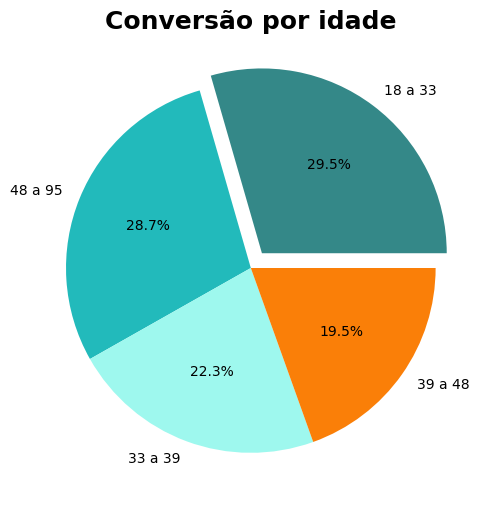

In [128]:
grafico_pizza(ages_converted["proportion"], ages_converted["age"], "Conversão por idade")

#####
**Convertidos por ocupação**

In [129]:
jobs_converted_proportion = features_freq_by_target(df, "y", "job", target_condition="yes", sort_ascending=False)
display(jobs_converted)

,job,y,proportion
12,student,yes,28.678038
13,retired,yes,22.791519
14,unemployed,yes,15.502686
15,management,yes,13.755551
16,admin.,yes,12.202669
17,self-employed,yes,11.842939
18,unknown,yes,11.805556
19,technician,yes,11.056996
20,services,yes,8.883004
21,housemaid,yes,8.790323


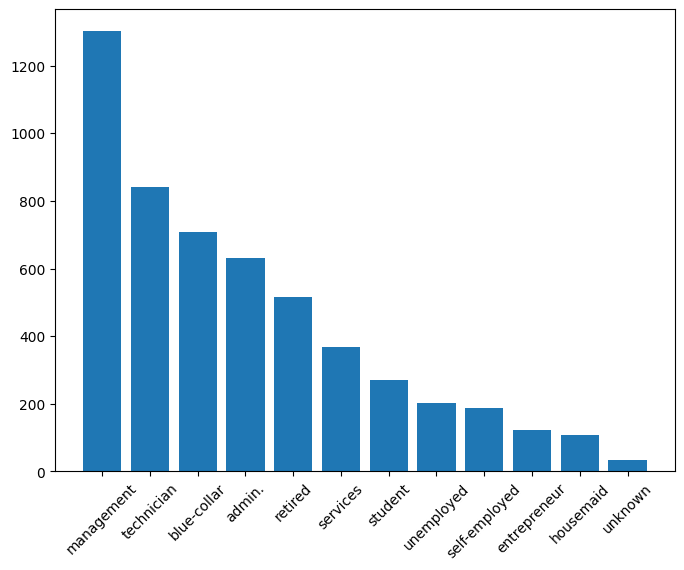

In [64]:
def grafico_barra(x: pd.core.series.Series, y: pd.core.series.Series, labels: pd.core.series.Series, title: str) -> None:
    """
    Esta função plota um gráfico de pizza.    

    Parâmetros:
    - `data`: recebe um objeto do tipo Série do Pandas, referente aos dados.
    - `labels`: recebe um objeto do tipo Série do Pandas, referente aos rótulos.
    - `title`: recebe uma string referente ao título do gráfico.
    """
    
    plt.figure(figsize=(6, 6))

    plt.bar(
        x,
        y,
        explode=(0.1, 0, 0, 0),
        labels=labels,
        colors=colors,
        autopct="%1.1f%%",
    )
    
    plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)
    
    plt.show()

plt.figure(figsize=(8, 6))

plt.bar(jobs_converted_counts["job"], jobs_converted_counts["count"])
plt.xticks(rotation=45)

# plt.title(title, fontsize=title_fontsize, fontweight=title_fontweight)

plt.show()

In [ ]:
target_features_analysis(df, "y", "education")

In [ ]:
target_features_analysis(df, "y", "default")

In [ ]:
balance_quantiles = pd.qcut(df["balance"], 4)
target_features_analysis(df, "balance_quantiles", "education")

In [ ]:
df["balance_quantiles"] = pd.qcut(df["balance"], 4)

In [ ]:
df.groupby("education")["balance_quantiles"].value_counts(normalize=True)

In [ ]:
df.groupby("marital")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("housing")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("loan")["y"].value_counts(normalize=True) * 100

In [ ]:
df.groupby("balance_quantiles")["y"].value_counts(normalize=True)